# Retrospective study on cartesian data

### - Effect of undersampling
### - PRE and SSIM indicators

In [ ]:
import json
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from time import time

sys.path.append(os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir ))

import function_reconstruction_cartesian
from Tools.load_save_utils import load_acquisition_reconstruction_from_nii, load_model_weights, _get_brain_acquisition_limits
from Tools.reconstruction_utils import NN_prediction
from Plot.plot_utils import plot_parameter_maps
from Neural_Networks.networks_new import initialize_network


## DATA

In [ ]:
path_to_summer_current = "/data_network/summer_projects/cungel/Current"

In [3]:
# cartesian FS
repertory = "2021_MRF_TC/MP3_projects/MP3_MRFUSE_20240424"

Philips_reco_filepath_P = os.path.join(path_to_summer_current,repertory, "Raw_data/MAPIRMAGE-D00-WIP_DelRec__bssfp_cart_FS_P_20240424-141344028.nii")
Philips_reco_filepath = os.path.join(path_to_summer_current,repertory, "Raw_data/MAPIRMAGE-D00-WIP_DelRec__bssfp_cart_FS_20240424-141343949.nii")

ROI_brain_map_filepath = os.path.join(path_to_summer_current,repertory, "ROI_data/MAPIRMAGE-D00-ROI-brain2D_20240426-085037219.nii")


## ROI brain mask

In [4]:
ROI_brain_map, _, _ = load_acquisition_reconstruction_from_nii(ROI_brain_map_filepath, nb_indents=1, v=False)
ROI_brain_map = np.rot90(ROI_brain_map == 1)

if ROI_brain_map.ndim == 2:
    ROI_brain_map = ROI_brain_map[:, :, None]

# mask
x_min, x_max, y_min, y_max = _get_brain_acquisition_limits(ROI_brain_map, crop_type='equal')

## Load the acquisition

In [ ]:
reco, affine, header = load_acquisition_reconstruction_from_nii(Philips_reco_filepath, nb_indents=0)
phase, _, _ = load_acquisition_reconstruction_from_nii(Philips_reco_filepath_P, nb_indents=0)
RECO = reco * np.exp(phase*1j)
RECO = np.rot90(RECO)
RECO[~ROI_brain_map] = 0

Loaded a 192x192 reconstruction with 1 slice and 260 pulses. 
Loaded a 192x192 reconstruction with 1 slice and 260 pulses. 


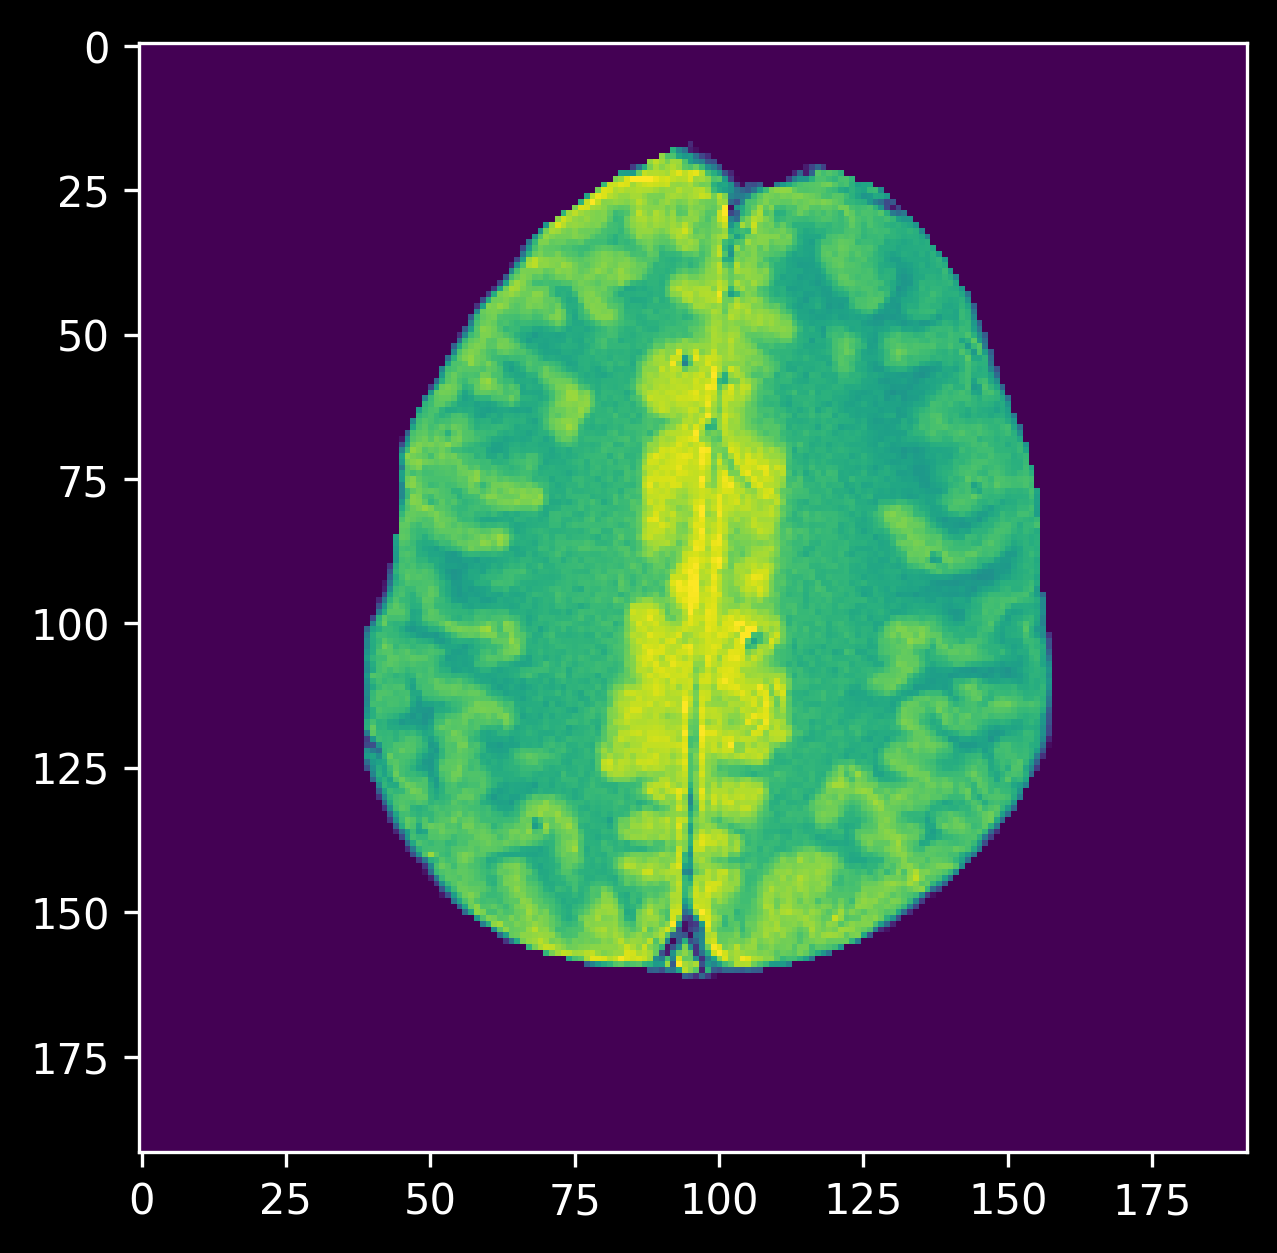

In [6]:
plt.imshow(np.abs(RECO[:,:,0,0]))

## FFT Reconstruction and undersampling

In [ ]:
percentage_undersampling = 90

inverse_fft, k_space_undersampled = function_reconstruction_cartesian.cartesian_undersampling(RECO, percentage_undersampling, return_ksp=True)

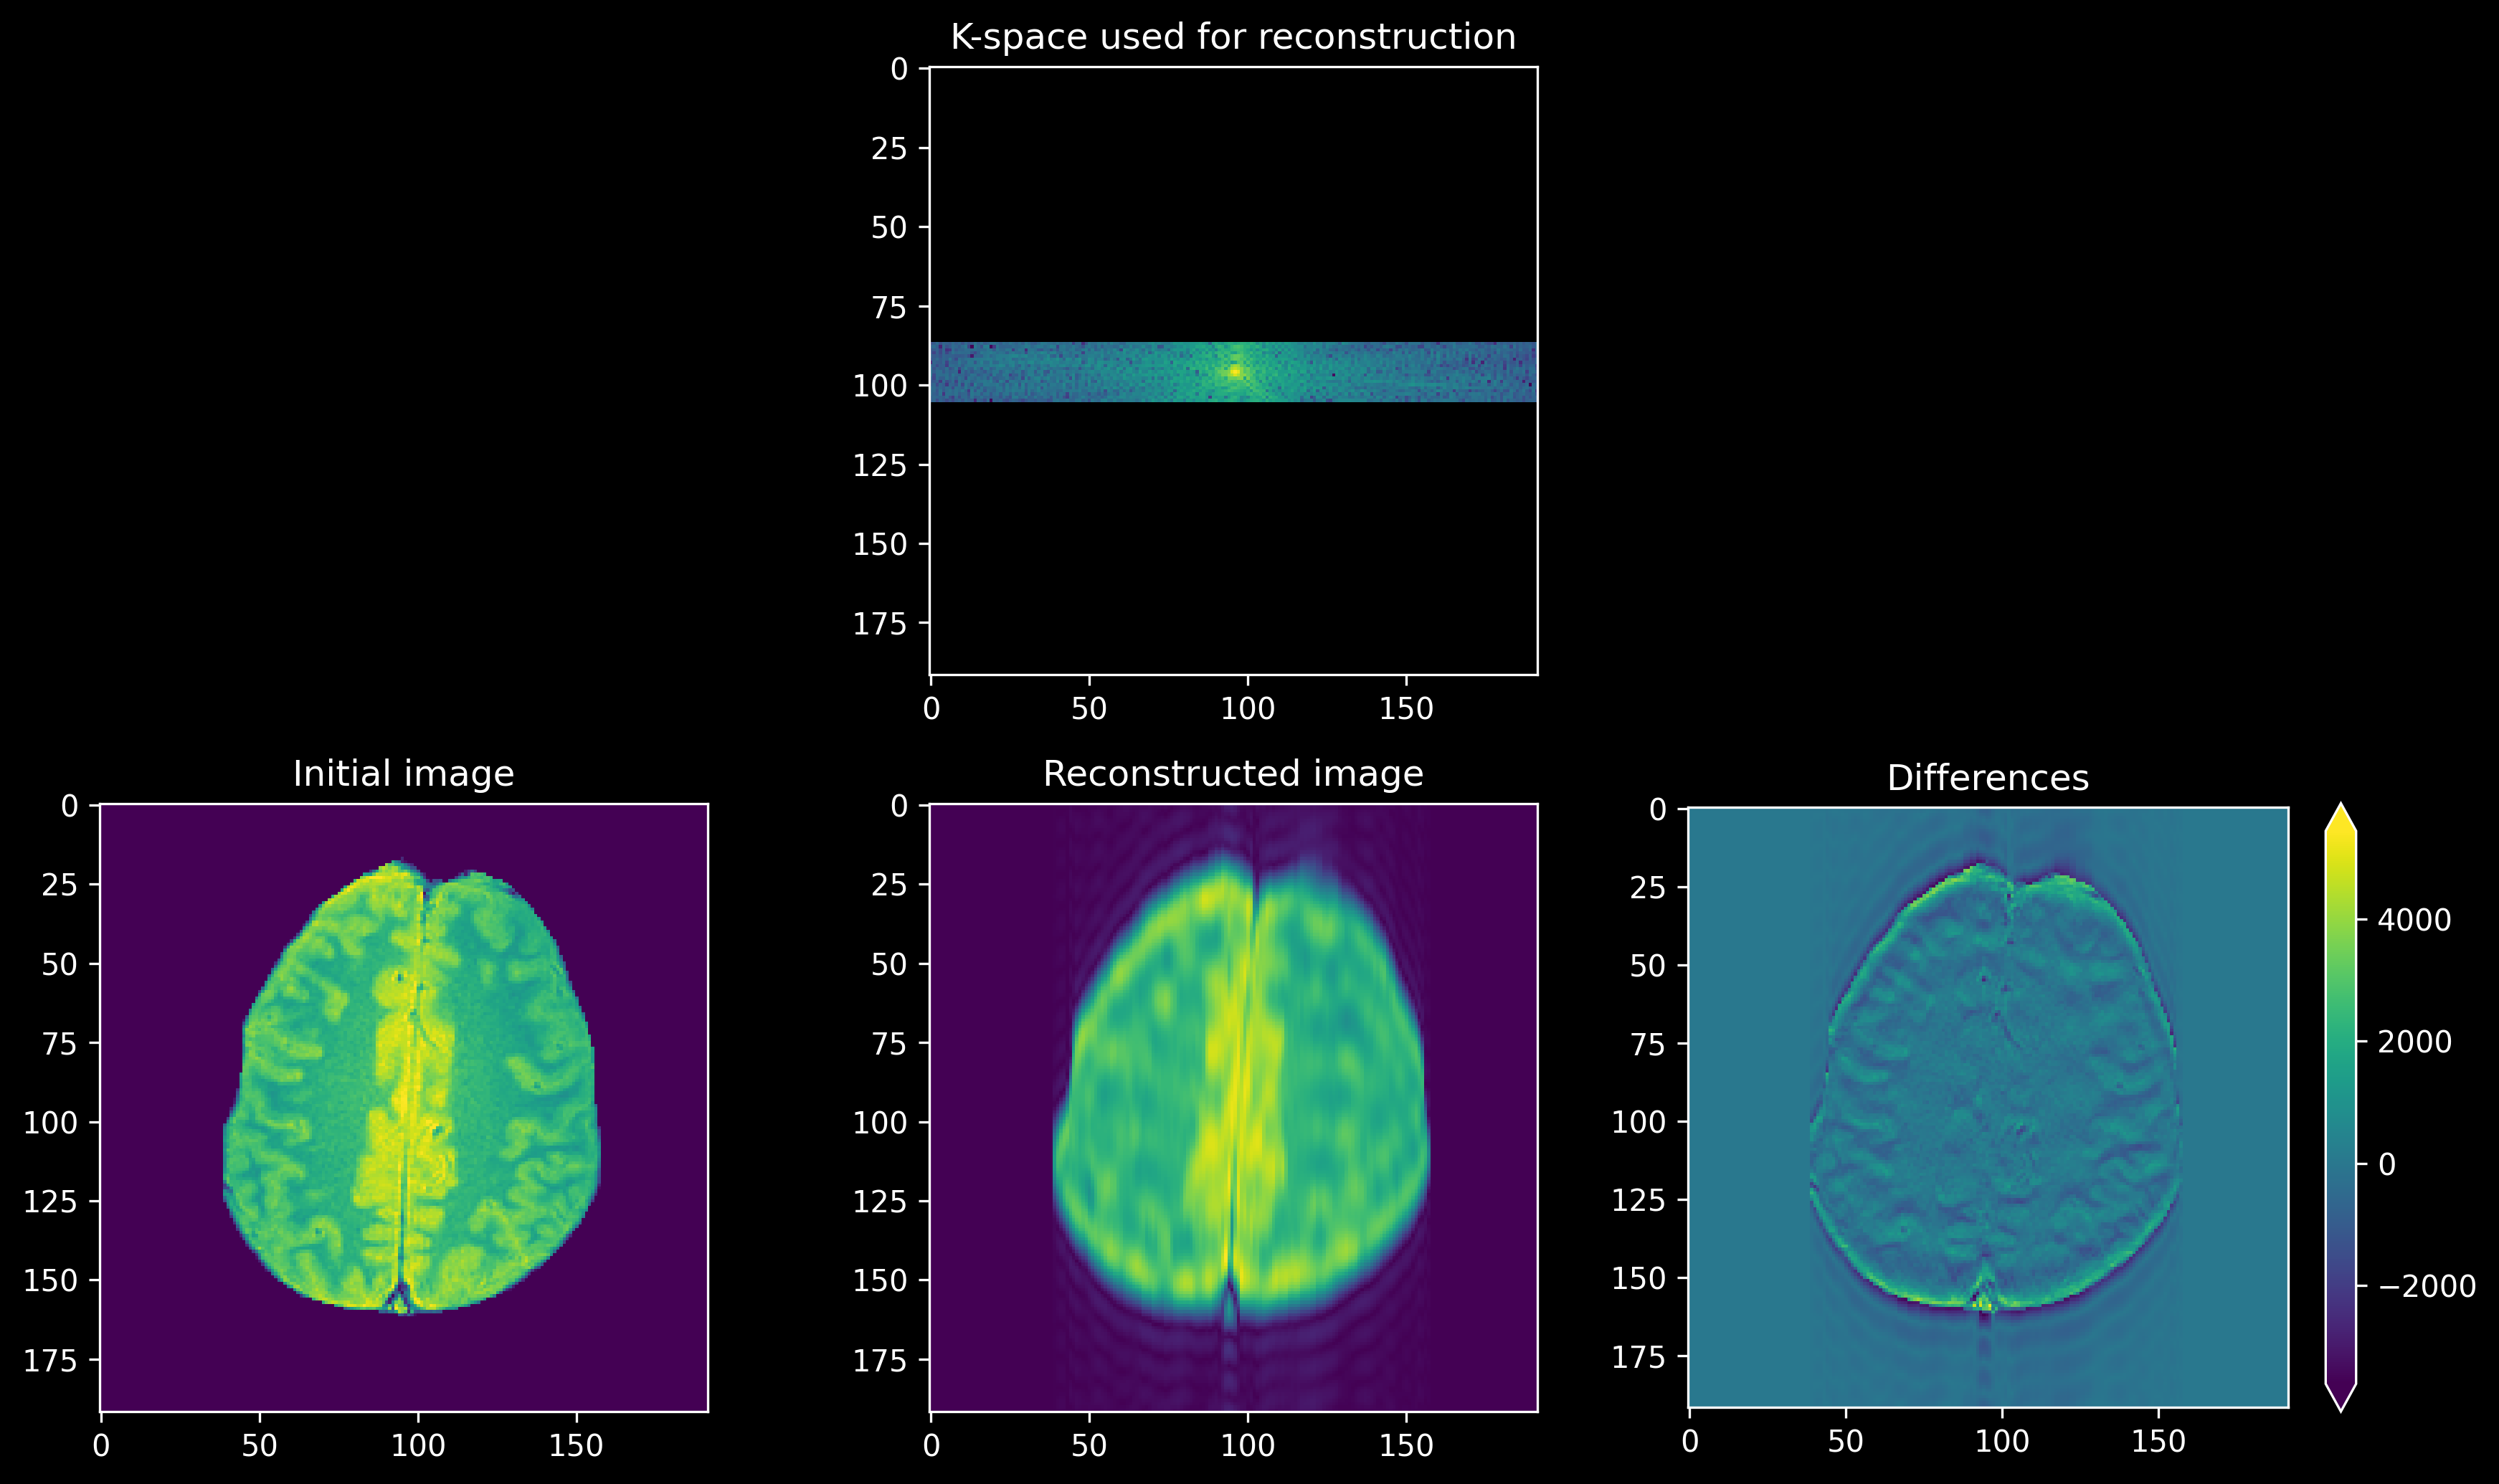

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))  
ax[0,1].imshow(np.log(np.abs((k_space_undersampled[:,:,:,0]))))
ax[0,1].set_title("K-space used for reconstruction")

ax[1,0].imshow(np.abs(RECO[:,:,:,0])  )
ax[1,0].set_title("Initial image")

ax[1,1].imshow(np.abs(inverse_fft[:,:,:,0]))
ax[1,1].set_title("Reconstructed image")

dsiff=ax[1,2].imshow(np.abs(RECO[:,:,:,0]) - np.abs(inverse_fft[:,:,:,0]))
ax[1,2].set_title("Differences")

cbar = fig.colorbar(dsiff, ax=ax[1,2], extend='both')
# Afficher la figure

ax[0, 0].axis('off')
ax[0, 2].axis('off')
plt.tight_layout()
plt.show()


## Compute parameter maps predictions

In [ ]:
training_path = os.path.join(path_to_summer_current, '2023_MRF_Collab/Lila/MARVEL_training/DICO8/train_updated_code_v2_LR0.9')

RECOS_INFOS = json.load(open(os.path.join(training_path, 'training_infos.json')))

In [ ]:
n_pulses = 260
n_epochs = 87

start = time()
print("\nINITIALIZE NETWORK")
NETWORK_INFOS = RECOS_INFOS["NETWORK_INFOS"]
learned_labels = ['T1', 'T2', 'df', 'B1rel', 'Vf', 'R']
n_parameters = len(learned_labels)
layer_B1_constraint_incorporation = NETWORK_INFOS.get("incorporate_B1_constraint", False)
network_name = NETWORK_INFOS["network_name"]
input_size = n_pulses 
layer_shapes = [input_size] + NETWORK_INFOS["hidden_layer_shapes"] + [n_parameters]
activations = NETWORK_INFOS["activations"]

NN = initialize_network(network_name, layer_shapes, activations, layer_B1_constraint_incorporation)

load_model_weights(NN, layer_shapes, adding_text='_{}epochs'.format(n_epochs), path_to_model=os.path.join(training_path, 'weights'))


INITIALIZE NETWORK
260


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 260, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100)            │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 75)             │         7,575 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50)             │         3,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,481 (126.88 KB)

 Trainable params: 32,481 (126.88 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
label_parameters = ['T1', 'T2', 'df', 'B1rel', 'Vf', 'R']


undersampled_RECO_normalized = np.abs(inverse_fft) / np.linalg.norm(np.abs(inverse_fft), axis=3)[:, :, :, None]
RECO_normalized = np.abs(RECO)/np.maximum(np.linalg.norm(np.abs(RECO), axis=3)[:, :, :, None], 1e-10)

NN_reconstruction_undersampled = NN_prediction(NN, undersampled_RECO_normalized, label_parameters, ROI_brain_map, batch_size=1024)
NN_reconstruction = NN_prediction(NN, RECO_normalized, label_parameters, ROI_brain_map, batch_size=1024)

NN_reconstruction_crop = NN_reconstruction[:, x_min:x_max+1, y_min:y_max+1]
NN_reconstruction_undersampled_crop = NN_reconstruction_undersampled[:, x_min:x_max+1, y_min:y_max+1]



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


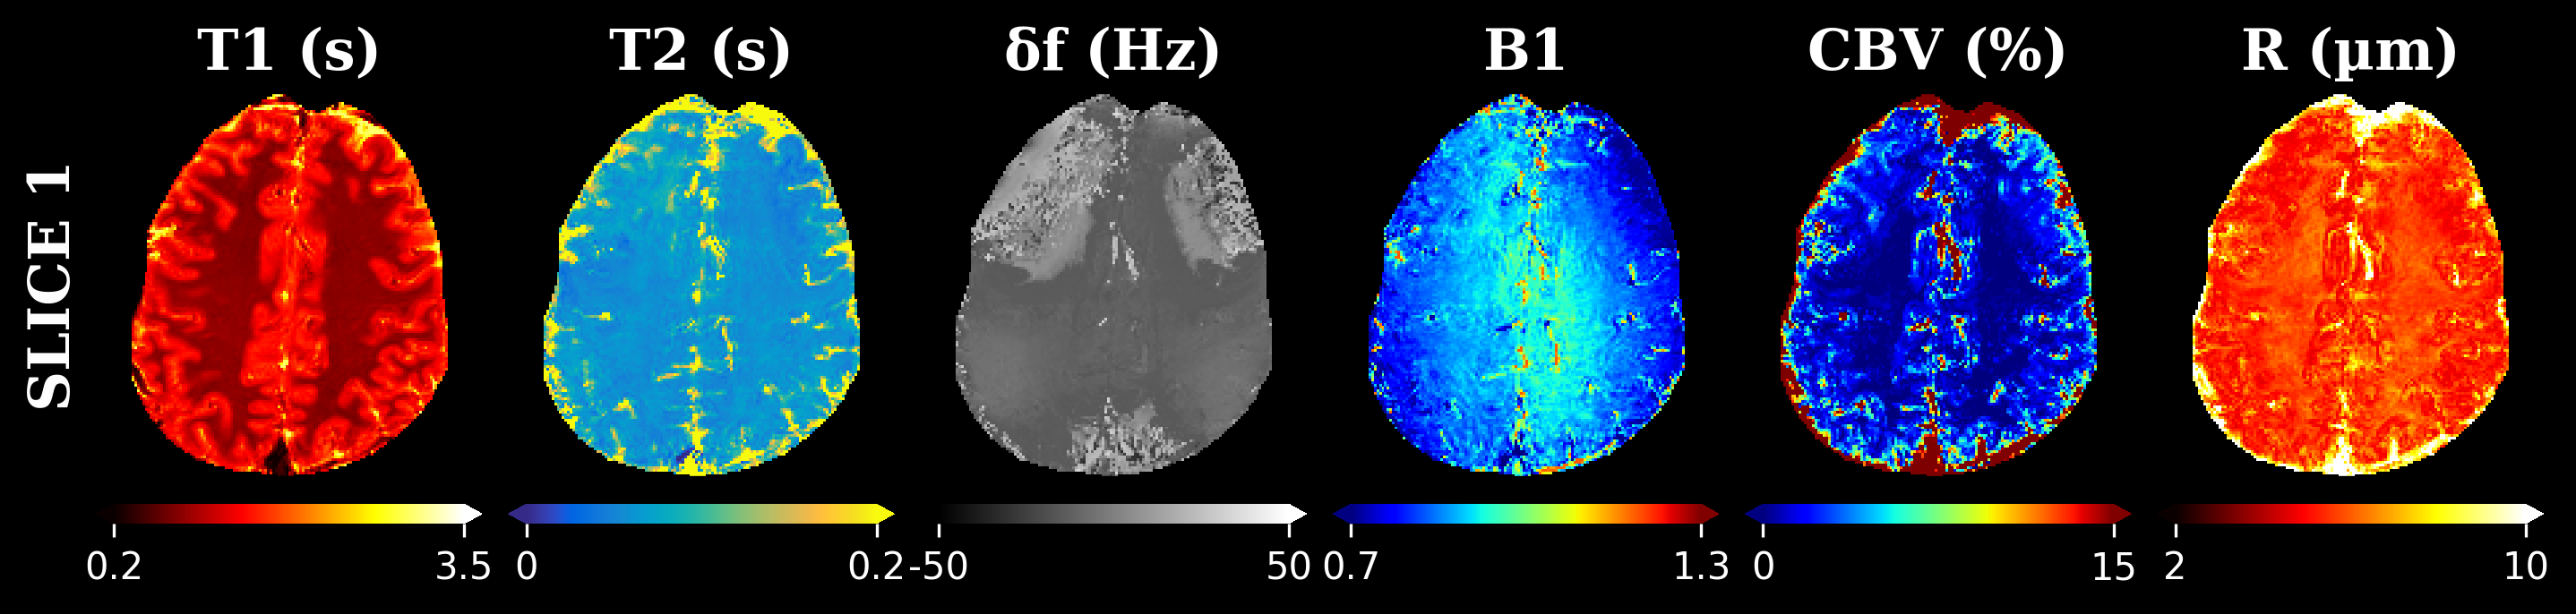

In [ ]:
fig = plot_parameter_maps(NN_reconstruction_crop, label_parameters, title='', path_to_data=training_path, file_name='{}_{}epochs'.format("first_test", n_epochs))

## Indicators

### SSIM

In [26]:
ROI_brain_map_crop = ROI_brain_map[x_min:x_max+1, y_min:y_max+1]

In [27]:
NN_reconstruction_crop[np.isnan(NN_reconstruction_crop)] = 1
NN_reconstruction_undersampled_crop[np.isnan(NN_reconstruction_undersampled_crop)] = 1

In [28]:
ssim = [metrics.structural_similarity(NN_reconstruction_crop[i,:,:,0]* ROI_brain_map_crop[:,:,0], NN_reconstruction_undersampled_crop[i,:,:,0]* ROI_brain_map_crop[:,:,0], data_range=NN_reconstruction_undersampled_crop[i,:,:,0].max() - NN_reconstruction_undersampled_crop[i,:,:,0].min(), full=True) for i in range (6)]

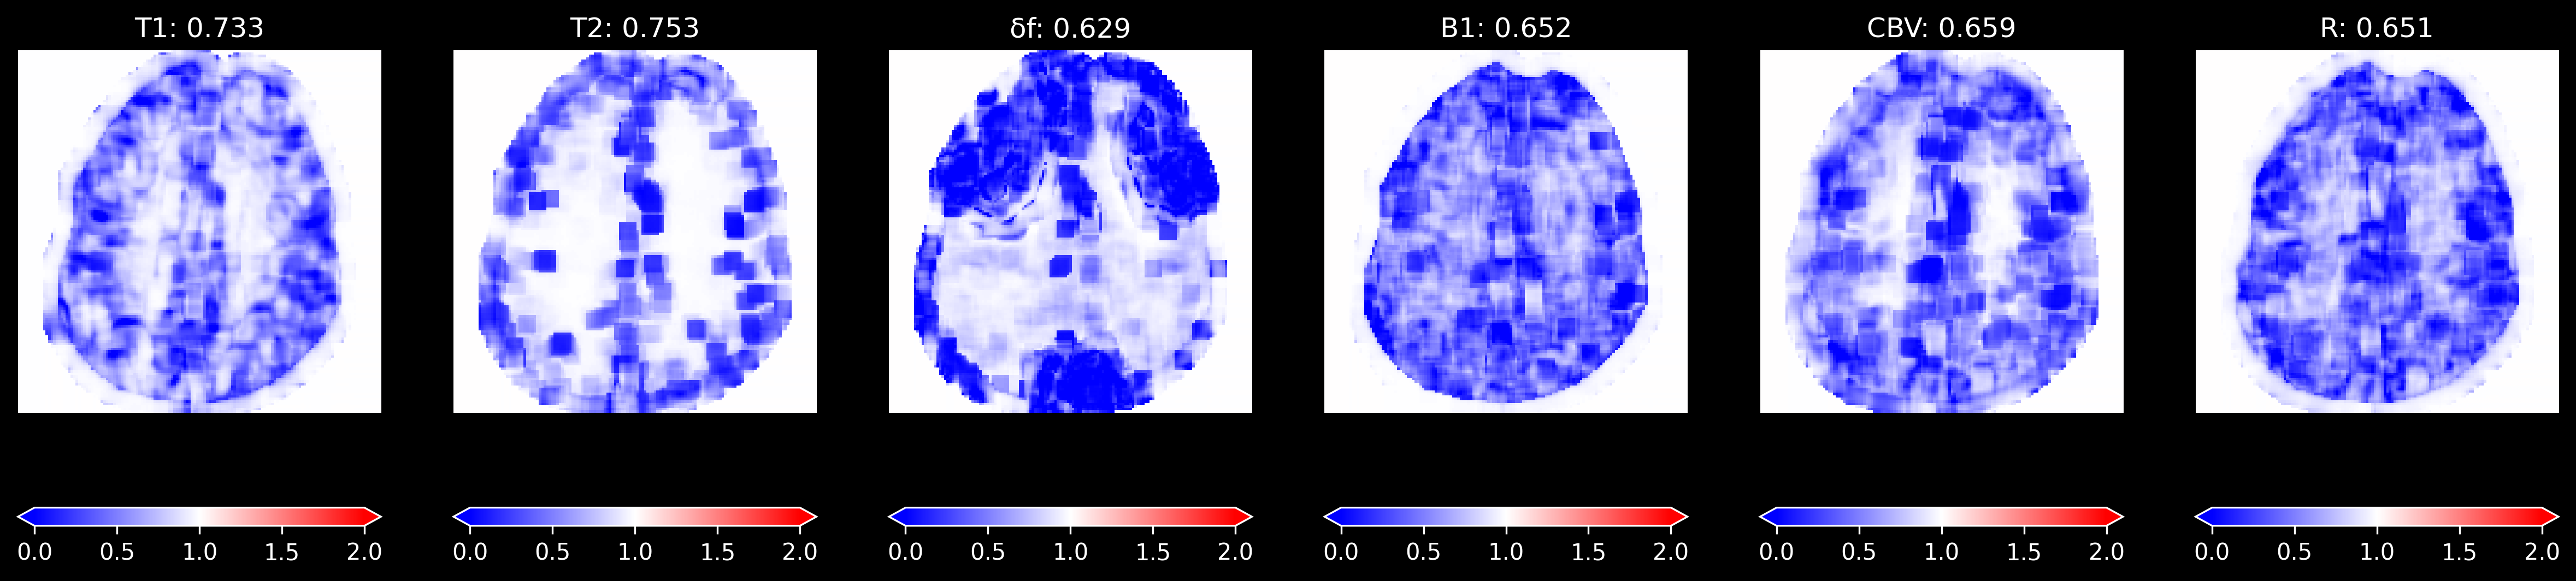

In [29]:
fig, ax = plt.subplots(1, 6, figsize=(20, 5))  


for i in range (NN_reconstruction_crop.shape[0]):
    norm = matplotlib.colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=2)
    
    fig_i = ax[i].imshow(ssim[i][1], cmap='bwr',  norm=norm)

    ax[i].set_title(f"{label[i]}: {ssim[i][0]:0.3f}")
    ax[i].grid(False)
    ax[i].axis('off')
    cbar = fig.colorbar(fig_i, ax=ax[i],  orientation='horizontal', extend='both')

### Loop on the undersampling ratio for PRE

In [30]:
label_parameters = ['T1', 'T2', 'df', 'B1rel', 'Vf', 'R']
pre_undersampling = []
pre_per_pic_undersampling =[]
ssim_undersampling = []
diff_undersampling=[]

RECO_normalized = np.abs(RECO)/np.maximum(np.linalg.norm(np.abs(RECO), axis=3)[:, :, :, None], 1e-10)

NN_reconstruction = NN_prediction(NN, RECO_normalized, label_parameters, ROI_brain_map, batch_size=1024)

NN_reconstruction_crop = NN_reconstruction[:, x_min:x_max+1, y_min:y_max+1]
NN_reconstruction_crop[np.isnan(NN_reconstruction_crop)] = 1

percentage_undersampling = [0,10,20,30,40,50,60,70,80,90,95]

for percent in percentage_undersampling :

    inverse_fft, k_space_undersampled =functions.cartesian_undersampling(RECO, percentage_undersampling=percent, return_ksp=True)

    undersampled_RECO_normalized = np.abs(inverse_fft) / np.linalg.norm(np.abs(inverse_fft), axis=3)[:, :, :, None]

    NN_reconstruction_undersampled = NN_prediction(NN, undersampled_RECO_normalized, label_parameters, ROI_brain_map, batch_size=1024)
    NN_reconstruction_undersampled_crop = NN_reconstruction_undersampled[:, x_min:x_max+1, y_min:y_max+1]
    NN_reconstruction_undersampled_crop[np.isnan(NN_reconstruction_undersampled_crop)] = 1

    pre, diff, pre_sum = functions.compare_pre(NN_reconstruction_crop, NN_reconstruction_undersampled_crop)

    pre_per_pix = pre_sum/ np.sum(ROI_brain_map)
    
    ssim = [metrics.structural_similarity(NN_reconstruction_crop[i,:,:,0]* ROI_brain_map_crop[:,:,0], NN_reconstruction_undersampled_crop[i,:,:,0]* ROI_brain_map_crop[:,:,0], data_range=NN_reconstruction_undersampled_crop[i,:,:,0].max() - NN_reconstruction_undersampled_crop[i,:,:,0].min(), full=True) for i in range (6)]
    diff_undersampling.append(diff)
    pre_undersampling.append(pre)
    pre_per_pic_undersampling.append(pre_per_pix)
    ssim_undersampling.append(ssim)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


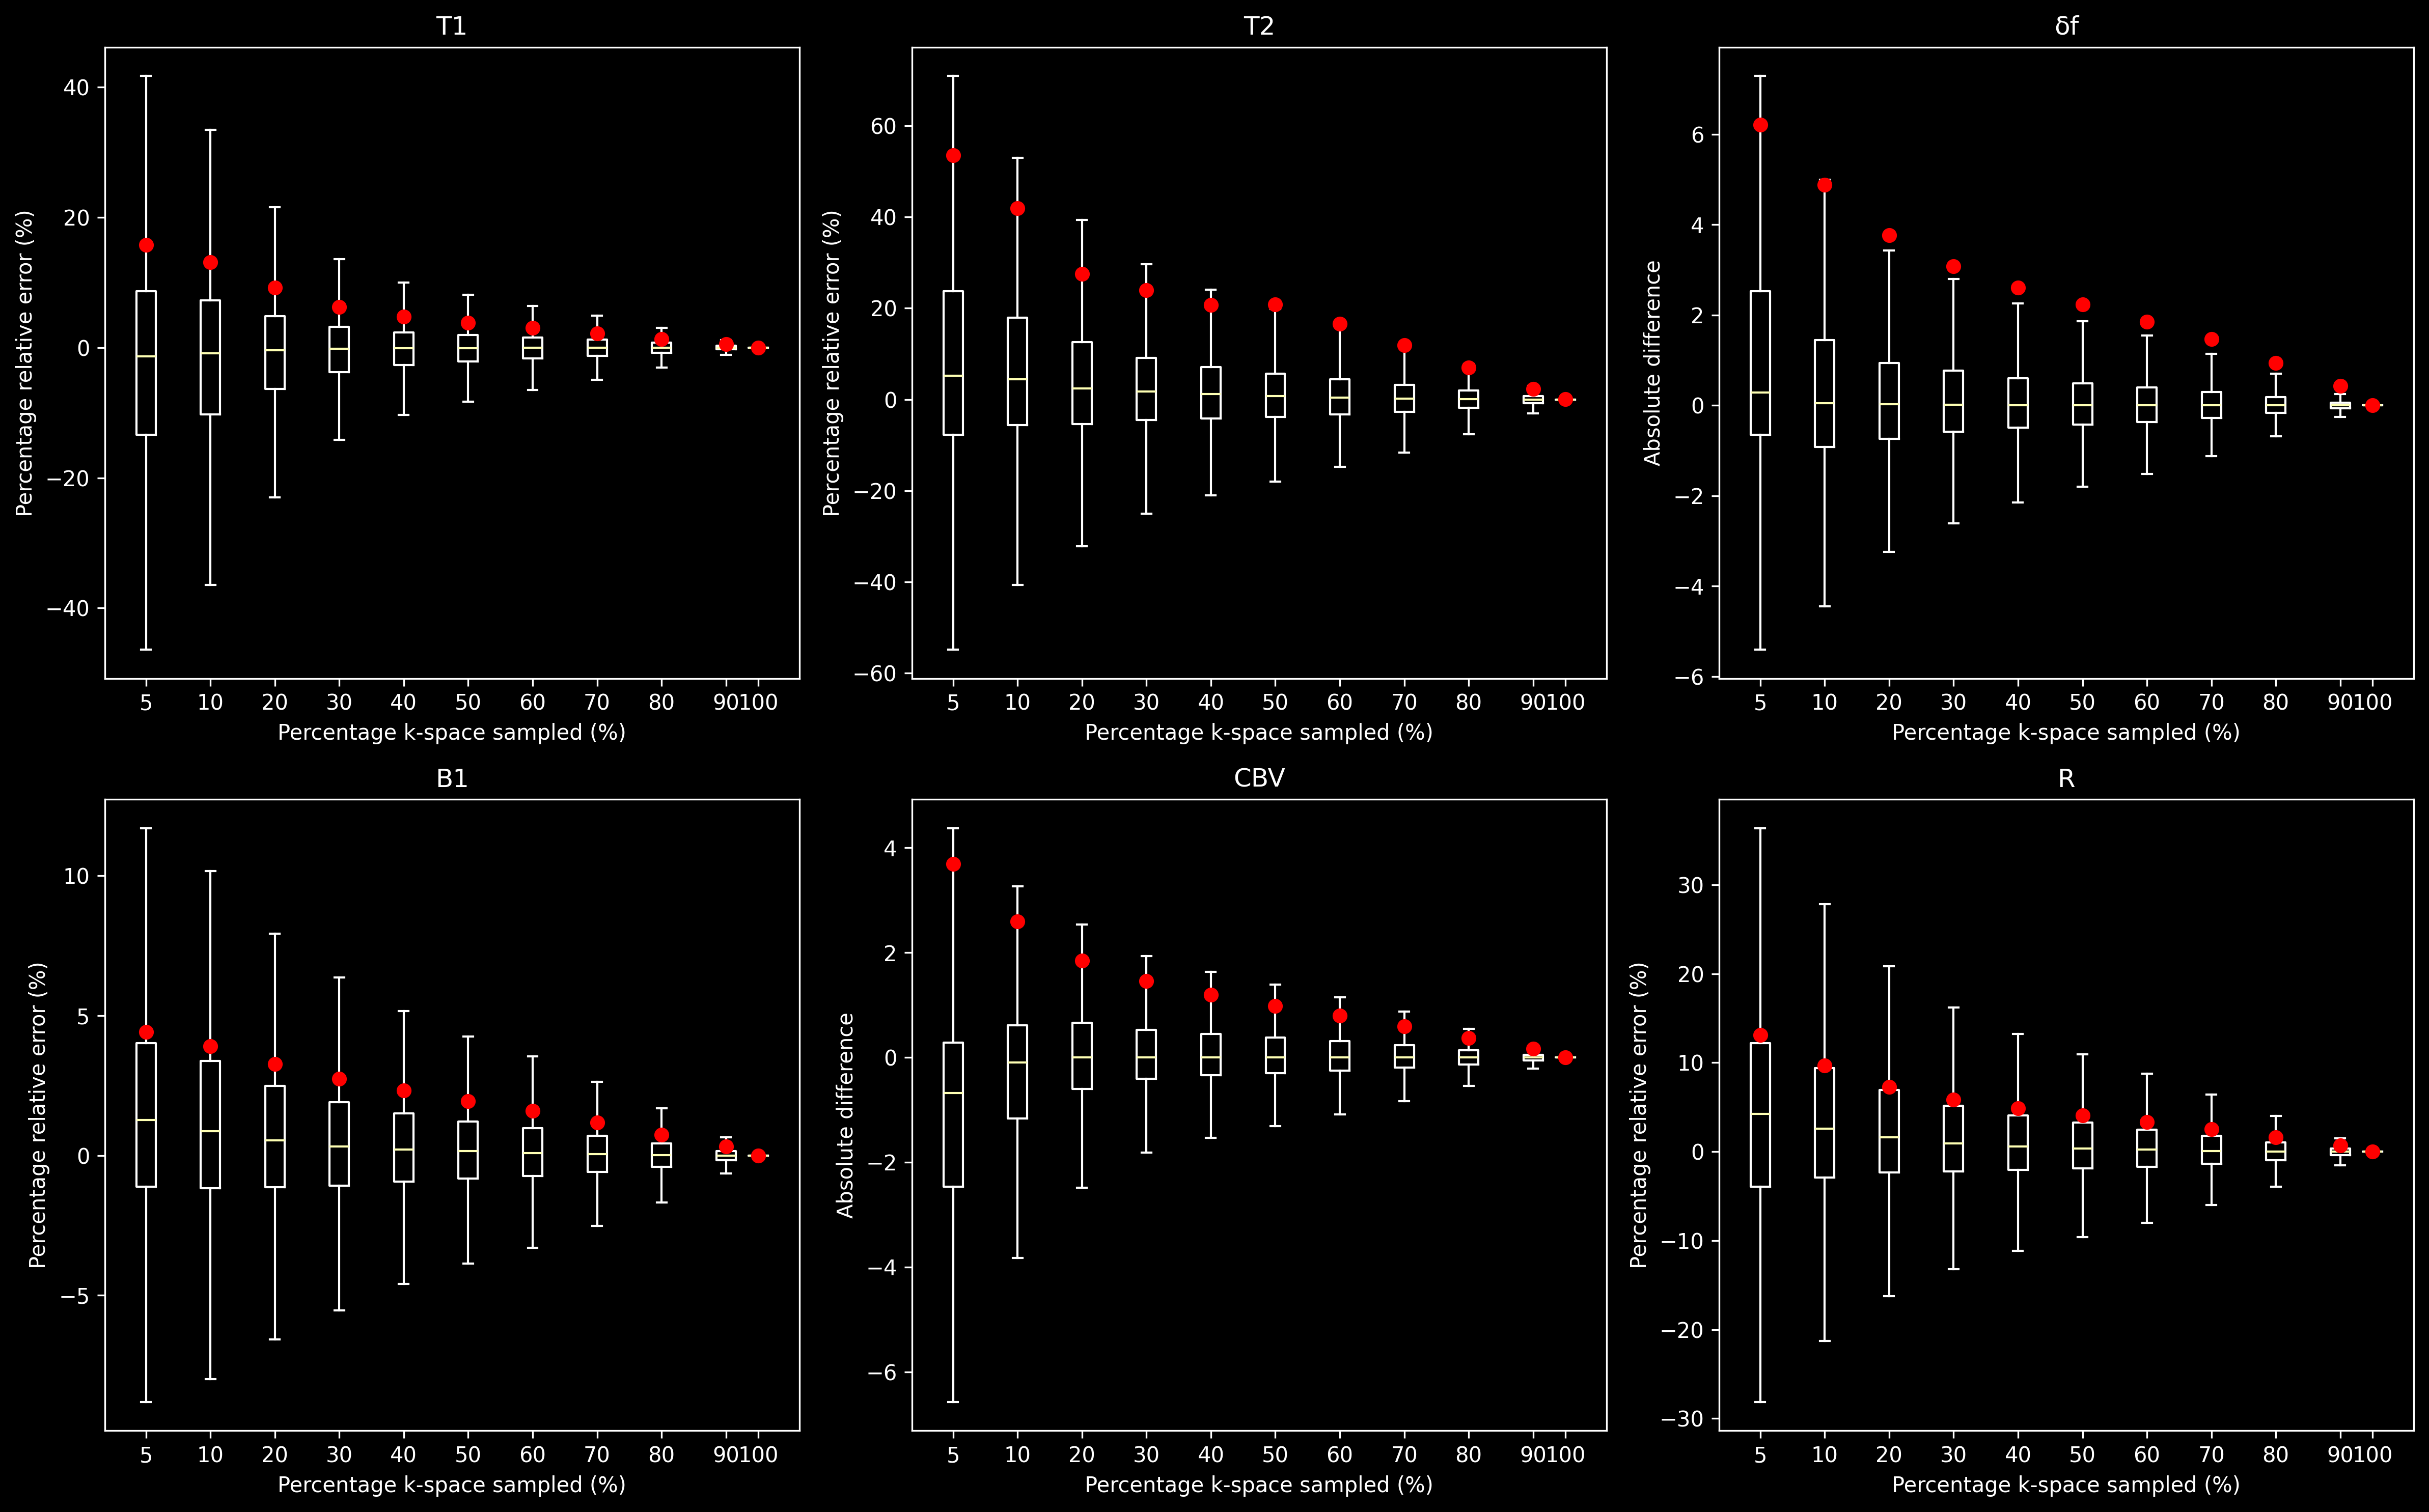

In [ ]:
label = ["T1", "T2", "δf", "B1", "CBV", "R"]
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
percentages = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 5]

for i in range(NN_reconstruction_crop.shape[0]):
    row = 0 if i < 3 else 1
    col = i if i < 3 else i - 3

    if i == 2 or i == 4:
        data = [np.asarray(diff_undersampling)[j, i, ROI_brain_map_crop].flatten() for j in range(11)]
        ylabel = "Absolute difference"
    else:
        data = [np.asarray(pre_undersampling)[j, i, ROI_brain_map_crop].flatten() for j in range(11)]
        ylabel = "Percentage relative error (%)"

    ax[row, col].boxplot(data, positions=percentages[::-1], sym='', widths=3)
    ax[row, col].scatter(percentages[::-1], np.asarray(pre_per_pic_undersampling)[:, i], color='red', zorder=3, label='Mean')

    ax[row, col].set_xticks(percentages[::-1])
    ax[row, col].set_xticklabels([str(p) for p in percentages])
    ax[row, col].invert_xaxis()
    ax[row, col].set_xlabel("Percentage k-space sampled (%)")
    ax[row, col].set_ylabel(ylabel)
    ax[row, col].set_title(label[i])

plt.tight_layout()
plt.show()